# Model Comparison: GBM vs Jump Diffusion vs Regime-Switching Volatility

This notebook consolidates and compares the backtesting results from the three models:
- GBM (baseline)
- Jump Diffusion (Poisson jumps)
- Regime-Switching volatility (2-state Markov chain)

**Inputs**
This notebook assumes the backtesting notebooks have already saved:
- `outputs/tables/gbm_backtest_results.csv` and `gbm_scorecard.csv`
- `outputs/tables/jd_backtest_results.csv` and `jd_scorecard.csv`
- `outputs/tables/rs_backtest_results.csv` and `rs_scorecard.csv`

**Outputs saved to Drive**
- `outputs/tables/model_comparison_scorecard.csv` (all models in one table)
- `outputs/tables/model_ranking_summary.csv` (simple “winner” view)
- `outputs/figures/*` comparison charts (breach rates, VaR lines, exceptions)





In [1]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [2]:
from pathlib import Path

PROJECT_NAME = "equity_var_backtesting"
BASE = Path("/content/drive/MyDrive") / PROJECT_NAME

DIRS = {
    "tables": BASE / "outputs" / "tables",
    "figures": BASE / "outputs" / "figures",
}

for p in DIRS.values():
    p.mkdir(parents=True, exist_ok=True)

paths = {
    "gbm_score": DIRS["tables"] / "gbm_scorecard.csv",
    "jd_score":  DIRS["tables"] / "jd_scorecard.csv",
    "rs_score":  DIRS["tables"] / "rs_scorecard.csv",

    "gbm_bt": DIRS["tables"] / "gbm_backtest_results.csv",
    "jd_bt":  DIRS["tables"] / "jd_backtest_results.csv",
    "rs_bt":  DIRS["tables"] / "rs_backtest_results.csv",
}
paths


{'gbm_score': PosixPath('/content/drive/MyDrive/equity_var_backtesting/outputs/tables/gbm_scorecard.csv'),
 'jd_score': PosixPath('/content/drive/MyDrive/equity_var_backtesting/outputs/tables/jd_scorecard.csv'),
 'rs_score': PosixPath('/content/drive/MyDrive/equity_var_backtesting/outputs/tables/rs_scorecard.csv'),
 'gbm_bt': PosixPath('/content/drive/MyDrive/equity_var_backtesting/outputs/tables/gbm_backtest_results.csv'),
 'jd_bt': PosixPath('/content/drive/MyDrive/equity_var_backtesting/outputs/tables/jd_backtest_results.csv'),
 'rs_bt': PosixPath('/content/drive/MyDrive/equity_var_backtesting/outputs/tables/rs_backtest_results.csv')}

In [3]:
!pip -q install pandas numpy matplotlib


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
plt.rcParams["figure.figsize"] = (12, 5)

VAR_LEVELS = [0.95, 0.99]


In [5]:
#Loading scorecards and stacking into one table
gbm_score = pd.read_csv(paths["gbm_score"])
jd_score  = pd.read_csv(paths["jd_score"])
rs_score  = pd.read_csv(paths["rs_score"])

all_score = pd.concat([gbm_score, jd_score, rs_score], ignore_index=True)

# standardize naming if needed
all_score["model"] = all_score["model"].replace({
    "RegimeSwitchVol": "RegimeSwitchVol",
    "JumpDiffusion": "JumpDiffusion",
    "GBM": "GBM"
})

all_score.head()


,ticker,model,var_level,n_obs,breaches,breach_rate,expected_rate
0,AAPL,GBM,0.95,2505,139,0.055489,0.05
1,AAPL,GBM,0.99,2505,56,0.022355,0.01
2,JPM,GBM,0.95,2505,113,0.045110,0.05
3,JPM,GBM,0.99,2505,60,0.023952,0.01
4,MSFT,GBM,0.95,2505,139,0.055489,0.05


In [6]:
#Adding “calibration quality” metric: breach rate error
all_score["breach_error"] = (all_score["breach_rate"] - all_score["expected_rate"]).abs()
all_score.sort_values(["var_level", "breach_error"]).head(12)


,ticker,model,var_level,n_obs,breaches,breach_rate,expected_rate,breach_error
32,TSLA,RegimeSwitchVol,0.95,2505,126,0.050299,0.05,0.000299
10,XOM,GBM,0.95,2505,124,0.049501,0.05,0.000499
24,AAPL,RegimeSwitchVol,0.95,2505,130,0.051896,0.05,0.001896
26,JPM,RegimeSwitchVol,0.95,2505,120,0.047904,0.05,0.002096
8,TSLA,GBM,0.95,2505,118,0.047106,0.05,0.002894
28,MSFT,RegimeSwitchVol,0.95,2505,134,0.053493,0.05,0.003493
34,XOM,RegimeSwitchVol,0.95,2505,134,0.053493,0.05,0.003493
6,SPY,GBM,0.95,2505,136,0.054291,0.05,0.004291
2,JPM,GBM,0.95,2505,113,0.045110,0.05,0.004890
0,AAPL,GBM,0.95,2505,139,0.055489,0.05,0.005489


In [7]:
out_score = DIRS["tables"] / "model_comparison_scorecard.csv"
all_score.to_csv(out_score, index=False)
print("Saved:", out_score)


Saved: /content/drive/MyDrive/equity_var_backtesting/outputs/tables/model_comparison_scorecard.csv


In [8]:
#Winner per ticker + VaR level (lowest breach error)
winner = (
    all_score.sort_values(["ticker", "var_level", "breach_error"])
    .groupby(["ticker", "var_level"], as_index=False)
    .first()
)

winner = winner[["ticker","var_level","model","breach_rate","expected_rate","breach_error","breaches","n_obs"]]
winner = winner.sort_values(["ticker","var_level"])

display(winner)


,ticker,var_level,model,breach_rate,expected_rate,breach_error,breaches,n_obs
0,AAPL,0.95,RegimeSwitchVol,0.051896,0.05,0.001896,130,2505
1,AAPL,0.99,RegimeSwitchVol,0.021956,0.01,0.011956,55,2505
2,JPM,0.95,RegimeSwitchVol,0.047904,0.05,0.002096,120,2505
3,JPM,0.99,RegimeSwitchVol,0.022754,0.01,0.012754,57,2505
4,MSFT,0.95,RegimeSwitchVol,0.053493,0.05,0.003493,134,2505
5,MSFT,0.99,GBM,0.022754,0.01,0.012754,57,2505
6,SPY,0.95,GBM,0.054291,0.05,0.004291,136,2505
7,SPY,0.99,RegimeSwitchVol,0.025549,0.01,0.015549,64,2505
8,TSLA,0.95,RegimeSwitchVol,0.050299,0.05,0.000299,126,2505
9,TSLA,0.99,GBM,0.019162,0.01,0.009162,48,2505


In [9]:
out_winner = DIRS["tables"] / "model_ranking_summary.csv"
winner.to_csv(out_winner, index=False)
print("Saved:", out_winner)


Saved: /content/drive/MyDrive/equity_var_backtesting/outputs/tables/model_ranking_summary.csv


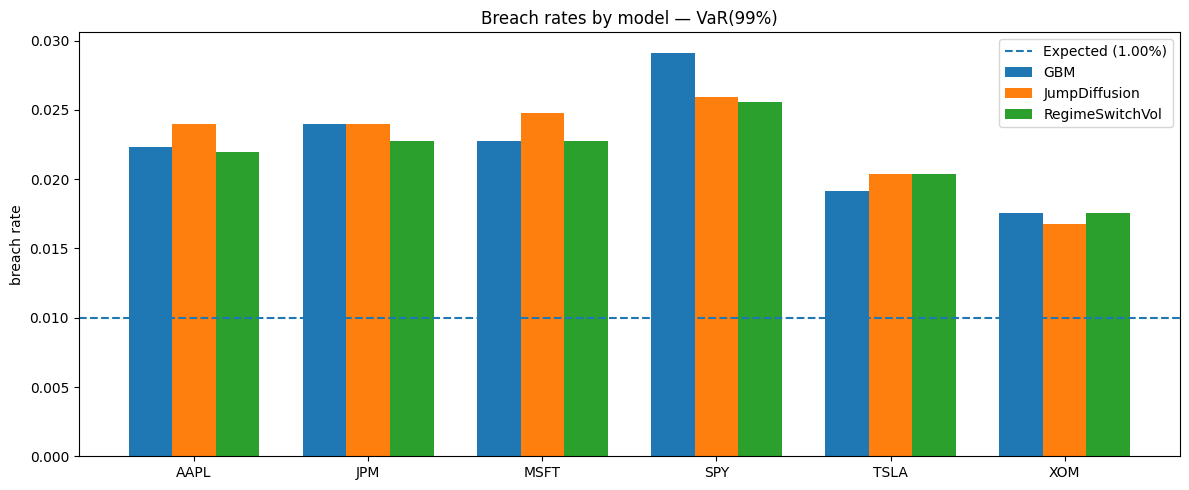

In [10]:
#Plot: breach rate by model (per ticker, VaR 99)
def plot_breach_rates(all_score_df: pd.DataFrame, var_level=0.99):
    sub = all_score_df[all_score_df["var_level"] == var_level].copy()

    tickers = sorted(sub["ticker"].unique())
    models = ["GBM", "JumpDiffusion", "RegimeSwitchVol"]

    x = np.arange(len(tickers))
    width = 0.25

    plt.figure(figsize=(12,5))
    for i, m in enumerate(models):
        y = []
        for t in tickers:
            val = sub[(sub["ticker"] == t) & (sub["model"] == m)]["breach_rate"]
            y.append(float(val.values[0]) if len(val) else np.nan)
        plt.bar(x + (i-1)*width, y, width=width, label=m)

    expected = 1 - var_level
    plt.axhline(expected, linestyle="--", label=f"Expected ({expected:.2%})")

    plt.xticks(x, tickers)
    plt.title(f"Breach rates by model — VaR({int(var_level*100)}%)")
    plt.ylabel("breach rate")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_breach_rates(all_score, 0.99)


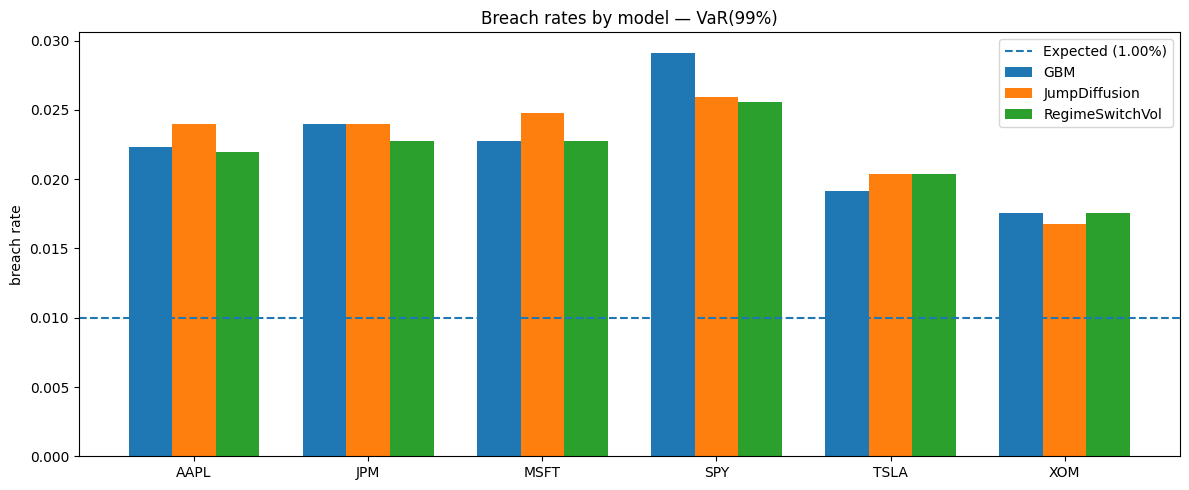

Saved figure: /content/drive/MyDrive/equity_var_backtesting/outputs/figures/comparison_breach_rates_VaR99.png


In [11]:
def save_breach_plot(all_score_df: pd.DataFrame, var_level: float, outpath: Path):
    sub = all_score_df[all_score_df["var_level"] == var_level].copy()

    tickers = sorted(sub["ticker"].unique())
    models = ["GBM", "JumpDiffusion", "RegimeSwitchVol"]

    x = np.arange(len(tickers))
    width = 0.25

    plt.figure(figsize=(12,5))
    for i, m in enumerate(models):
        y = []
        for t in tickers:
            val = sub[(sub["ticker"] == t) & (sub["model"] == m)]["breach_rate"]
            y.append(float(val.values[0]) if len(val) else np.nan)
        plt.bar(x + (i-1)*width, y, width=width, label=m)

    expected = 1 - var_level
    plt.axhline(expected, linestyle="--", label=f"Expected ({expected:.2%})")

    plt.xticks(x, tickers)
    plt.title(f"Breach rates by model — VaR({int(var_level*100)}%)")
    plt.ylabel("breach rate")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    print("Saved figure:", outpath)

fig_path = DIRS["figures"] / "comparison_breach_rates_VaR99.png"
save_breach_plot(all_score, 0.99, fig_path)


In [12]:
gbm_bt = pd.read_csv(paths["gbm_bt"], parse_dates=["date"])
jd_bt  = pd.read_csv(paths["jd_bt"], parse_dates=["date"])
rs_bt  = pd.read_csv(paths["rs_bt"], parse_dates=["date"])

gbm_bt["model"] = "GBM"
jd_bt["model"]  = "JumpDiffusion"
rs_bt["model"]  = "RegimeSwitchVol"

bt_all = pd.concat([gbm_bt, jd_bt, rs_bt], ignore_index=True)
bt_all.head()


,date,mu_annual,sigma_annual,realized_logret,realized_simple_return,realized_loss,VaR_95,ES_95,breach_95,VaR_99,ES_99,breach_99,ticker,model,lambda_annual,muJ,sigmaJ,jump_threshold,n_jumps_window,sigma_low_annual,sigma_high_annual,P00,P01,P10,P11,vol_threshold,current_state,n_low,n_high,sim_high_state_frac
0,2016-01-06,-0.020188,0.267325,-0.019763,-0.019569,0.019569,0.028005,0.034702,False,0.038504,0.044041,False,AAPL,GBM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-07,-0.016991,0.267002,-0.043121,-0.042205,0.042205,0.027419,0.033994,True,0.038179,0.044202,True,AAPL,GBM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-08,-0.036848,0.267727,0.005274,0.005288,-0.005288,0.027533,0.034117,False,0.038389,0.044183,False,AAPL,GBM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-11,-0.093894,0.270777,0.016062,0.016192,-0.016192,0.028242,0.035179,False,0.039656,0.044655,False,AAPL,GBM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-12,-0.126322,0.268128,0.014409,0.014513,-0.014513,0.028172,0.034677,False,0.038702,0.043965,False,AAPL,GBM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


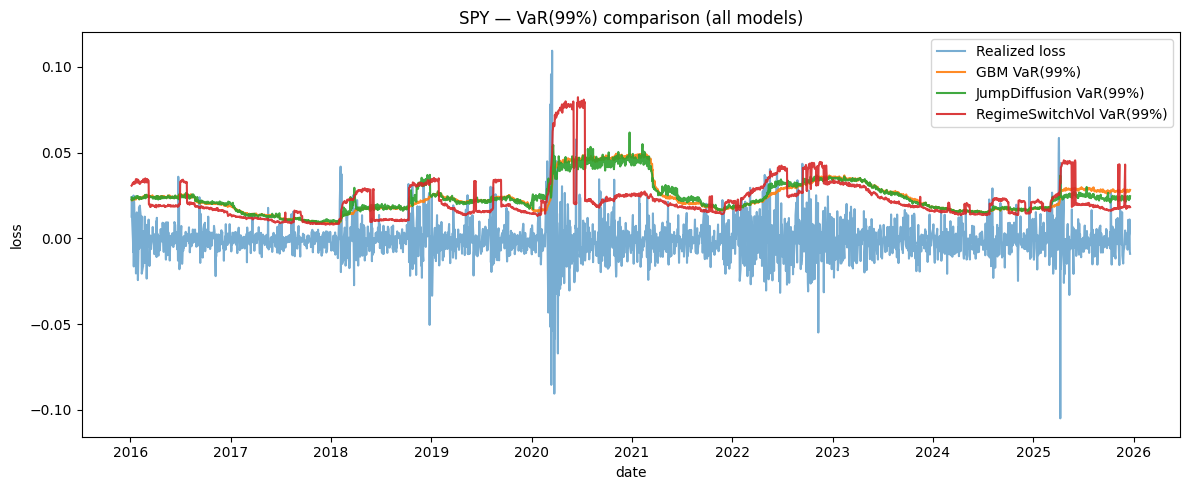

In [13]:
#Plotting: realized loss vs VaR99 for 3 models on one ticker
def plot_var99_overlay(bt_all_df: pd.DataFrame, ticker="SPY"):
    sub = bt_all_df[bt_all_df["ticker"] == ticker].sort_values("date").copy()

    plt.figure(figsize=(12,5))
    # realized loss (same across models, but we can just plot it from one model)
    realized = sub[sub["model"] == "GBM"][["date","realized_loss"]].dropna()
    plt.plot(realized["date"], realized["realized_loss"], label="Realized loss", alpha=0.6)

    for m in ["GBM", "JumpDiffusion", "RegimeSwitchVol"]:
        s = sub[sub["model"] == m]
        plt.plot(s["date"], s["VaR_99"], label=f"{m} VaR(99%)", alpha=0.9)

    plt.title(f"{ticker} — VaR(99%) comparison (all models)")
    plt.xlabel("date")
    plt.ylabel("loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_var99_overlay(bt_all, "SPY")


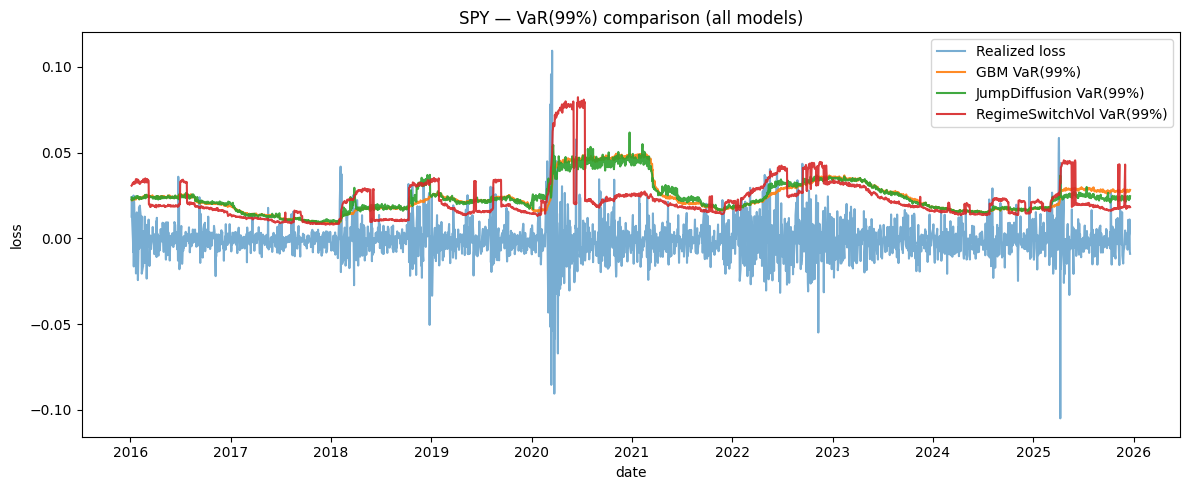

Saved figure: /content/drive/MyDrive/equity_var_backtesting/outputs/figures/comparison_VaR99_overlay_SPY.png


In [14]:
def save_var99_overlay(bt_all_df: pd.DataFrame, ticker: str, outpath: Path):
    sub = bt_all_df[bt_all_df["ticker"] == ticker].sort_values("date").copy()

    plt.figure(figsize=(12,5))
    realized = sub[sub["model"] == "GBM"][["date","realized_loss"]].dropna()
    plt.plot(realized["date"], realized["realized_loss"], label="Realized loss", alpha=0.6)

    for m in ["GBM", "JumpDiffusion", "RegimeSwitchVol"]:
        s = sub[sub["model"] == m]
        plt.plot(s["date"], s["VaR_99"], label=f"{m} VaR(99%)", alpha=0.9)

    plt.title(f"{ticker} — VaR(99%) comparison (all models)")
    plt.xlabel("date")
    plt.ylabel("loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    print("Saved figure:", outpath)

fig_path = DIRS["figures"] / "comparison_VaR99_overlay_SPY.png"
save_var99_overlay(bt_all, "SPY", fig_path)


In [15]:
#Final table
headline = winner.copy()
headline["var_level"] = headline["var_level"].map({0.95: "95%", 0.99: "99%"})
headline = headline.rename(columns={
    "model": "best_model",
    "breach_rate": "breach_rate_actual",
    "expected_rate": "breach_rate_expected"
})
headline = headline.sort_values(["ticker","var_level"])

display(headline)


,ticker,var_level,best_model,breach_rate_actual,breach_rate_expected,breach_error,breaches,n_obs
0,AAPL,95%,RegimeSwitchVol,0.051896,0.05,0.001896,130,2505
1,AAPL,99%,RegimeSwitchVol,0.021956,0.01,0.011956,55,2505
2,JPM,95%,RegimeSwitchVol,0.047904,0.05,0.002096,120,2505
3,JPM,99%,RegimeSwitchVol,0.022754,0.01,0.012754,57,2505
4,MSFT,95%,RegimeSwitchVol,0.053493,0.05,0.003493,134,2505
5,MSFT,99%,GBM,0.022754,0.01,0.012754,57,2505
6,SPY,95%,GBM,0.054291,0.05,0.004291,136,2505
7,SPY,99%,RegimeSwitchVol,0.025549,0.01,0.015549,64,2505
8,TSLA,95%,RegimeSwitchVol,0.050299,0.05,0.000299,126,2505
9,TSLA,99%,GBM,0.019162,0.01,0.009162,48,2505


In [16]:
out_headline = DIRS["tables"] / "model_comparison_headline.csv"
headline.to_csv(out_headline, index=False)
print("Saved:", out_headline)


Saved: /content/drive/MyDrive/equity_var_backtesting/outputs/tables/model_comparison_headline.csv
